# Comparing grbsens and ctools

In [1]:

import logging
import random
from pathlib import Path

import astropy.units as u

# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.io import fits
from gammapy.modeling.models import PowerLawSpectralModel
from scipy import integrate
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.optimize import brentq
from tqdm import tqdm

from gravitational_wave_toy.ctairf import IRFHouse
from gravitational_wave_toy.observe import GRB, oGRB
from gravitational_wave_toy.sensitivity import SensitivityCtools, SensitivityGammapy, gamma_sens_old
from gravitational_wave_toy.util import suppress_warnings_and_logs

sns.set()
    
# set logging level to debug
# logging.basicConfig(level=logging.DEBUG)


### Load in IRF (South Alpha z20 prod5-v0.1)

In [3]:
house = IRFHouse(base_directory="/Users/jarred/Documents/Work/CTA-IRFs")

irf = house.get_irf(
    site="south",
    configuration="alpha",
    zenith=20,
    duration=1800,
    azimuth="average",
    version="prod5-v0.1",
)

### Load in ctools sensitivity
- direct from file, no fitting atm

Text(0, 0.5, 'Log Sensitivity [erg cm^-2 s^-1]')

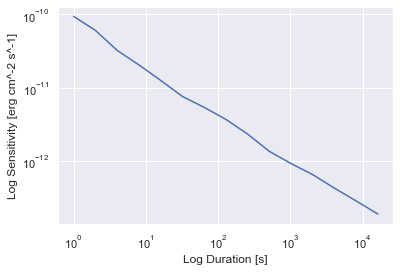

In [32]:
grbsens_dir = Path(
    "/Users/jarred/Documents/Work/gravitational_wave_toy/CTA_sensitivity/grbsens_output_v3_Sep_2022/alpha_configuration"
)
file = (
    grbsens_dir
    / f"grbsens-5.0sigma_t1s-t16384s_irf-{irf.site.name.capitalize()}_z{irf.zenith}_0.5h.txt"
)
cols = [
    "duration",
    "crab_flux",
    "photon_flux",
    "energy_flux",
    "sensitivity",
]

ctools_curve = pd.read_csv(file, sep="\t", comment="#", names=cols)

plt.loglog(ctools_curve["duration"], ctools_curve["sensitivity"], label="ctools")
plt.xlabel("Log Duration [s]")
plt.ylabel("Log Sensitivity [erg cm^-2 s^-1]")

### Load in gammapy sensitivity
- first try with a fixed power law modela

In [34]:
ctools_curve.duration.to_numpy()

array([    1,     2,     4,     8,    16,    32,    64,   128,   256,
         512,  1024,  2048,  4096,  8192, 16384])

In [35]:
times = ctools_curve.duration.to_numpy()
tables = {}
gammapy_res = {}

model = PowerLawSpectralModel(
    index=2.1, amplitude="5.7e-13 cm-2 s-1 TeV-1", reference="1 TeV"
)

for duration in tqdm(
    times,
    desc=f"Processing IRF: {irf.version} {irf.site} {irf.zenith}deg {irf.duration}s",
):
    s = gamma_sens_old(
        irf=irf.filepath,
        observatory=f"cta_{irf.site.name}",
        duration=duration,
        model=model,
        radius=3.0,
        min_energy=0.03,
        max_energy=10,
        sigma=5,
        bins=1,
        offset=0.0,
    )

    tables[duration] = s
    gammapy_res[duration] = s["e2dnde"][0]

Processing IRF: prod5-v0.1 Site.south 20deg 1800s:   0%|          | 0/15 [00:00<?, ?it/s]

/Users/jarred/Documents/Work/gravitational_wave_toy/.venv/lib/python3.10/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Processing IRF: prod5-v0.1 Site.south 20deg 1800s:   7%|▋         | 1/15 [00:00<00:04,  3.18it/s]/Users/jarred/Documents/Work/gravitational_wave_toy/.venv/lib/python3.10/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Processing IRF: prod5-v0.1 Site.south 20deg 1800s:  13%|█▎        | 2/15 [00:00<00:03,  3.53it/s]/Users/jarred/Documents/Work/gravitational_wave_toy/.venv/lib/python3.10/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Processing IRF: prod5-v0.1 Site.south 20deg 1800s:  20%|██        | 3/15 [00:00<00:03,  3.64it/s]/Users/jarred/Documents/Work

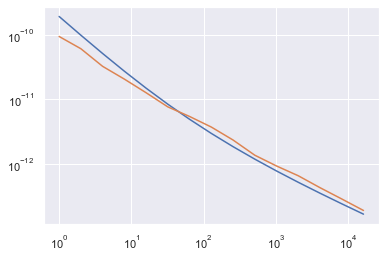

In [41]:
plt.loglog(times, gammapy_res.values(), label="gammapy")
plt.loglog(ctools_curve["duration"], ctools_curve["sensitivity"], label="ctools")